# Traditional Machine Learning Example

In this tutorial we will use traditional machine learning to propose a model for a "puzzle". This puzzle is a real example of problems commonly seen in real life. This example in particular, corresponds
to a Kaggle competition and has been used during the interview process of many companies, such as banks.

We will be using [scikit-learn](https://scikit-learn.org) and [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/api.html) to tackle this problem.

The data is available for download [here](https://drive.google.com/file/d/1KDP_CVnTQNCnouw7qeM39Lhe22oPUKJL/view?usp=sharing).

## Puzzle Overview
As a credit company, it is important to know beforehand who is able to pay their loans and who is not. The goal of this puzzle is to build a statistical/machine learning model to figure out which clients are able to honor their debt.

## Structure

Besides these instructions, the ZIP file contains 2 datasets in CSV format:
- puzzle_train_dataset.csv : training dataset
- puzzle_test_dataset.csv : test dataset. It contains the same columns as the training dataset, except for the `default` variable

Your goal is to predict the probability of default , which is identified by the default variable in the training dataset.

## Explanation of the solution in this notebook
The problem at hand is a binary supervised classification problem that has the goal to predict loan defaults. Some samples in the train set did not have labels and were discarded, resulting in a final train set with 59966 training samples. The train dataset is unbalanced with a non-default/default  proportion of 5.3/1. Several samples had missing features. ‘credit_limit’ information, the fourth most important feature according to my model, was missing on 18,779 samples. Features that could potentially pose ethical problems, such as gender, zip code, and job name were dropped from the model. Other features like "reason","channel","n_issues" and "ok_since" were not considered, because initial tests showed that their influence was negligible in the final results. For instance, the feature “channel” is the same for every sample in the dataset, therefore adding no extra information. I included dummy binary features that served as flags to whether a feature was missing or not. The categorical variables 'score_1', 'score_2', 'real_state' were encoded using a one-hot-encoding scheme. Missing features were replaced by the value -1. Initial experiments that replaced missing features by the median and the mean showed no improvement to the model. At the end, I had a total of 77 features. My experimental setup consisted of a stratified (i.e., proportion preserving) 5-fold cross-validation approach. I tested two classifiers: a random forest (RF) and a balanced random forests (BRF). The BRF has the advantage of dealing with the problem of the  non-default/default proportion unbalance. Both classifiers had similar areas under the curve metrics (RF: 0.761; BRF: 0.763). RF achieved a higher accuracy (0.853), but at the expense of having a really poor performance classifying the defaults. The default class is arguably the most important in this group, which is the reason why I chose as my final model the BRF classifier. My model was based on online resources credited in my script.

In [1]:
%matplotlib inline
import numpy as np # makes Python better than MATLAB for array manipulation
import pandas as pd # For reading and putting our CSV data in a shape suitable for processing 

# Traditional ML library
import sklearn 
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier # ML for imbalanced problems
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import matplotlib.pylab as plt # for plotting


# Features/columns to be removed for several reasons: ethical irrelevant feature, etc
to_remove = ["job_name", "reason","channel","n_issues","ok_since","zip","gender"] 

# Read train and test data and drop columns
df_train = pd.read_csv("../Data/puzzle/puzzle_train_dataset.csv").set_index("ids").drop(to_remove, axis=1)
df_test = pd.read_csv("../Data/puzzle/puzzle_test_dataset.csv").set_index("ids").drop(to_remove, axis=1)

print("Nb. of train samples: %d" %df_train.shape[0])
print("Number of test samples:  %d" %df_test.shape[0])
print("Nb. features: %d" %(df_train.shape[1]-1))

# Remove samples with missing labels
df_train = df_train[pd.notnull(df_train['default'])]
df_train["default"] = df_train["default"].astype("int")

print("Nb. of train samples after removing samples with no label: %d" %df_train.shape[0])
print("Classes ratio (False/True): %f" %((df_train["default"] == 0).sum()/(df_train["default"] == 1).sum()))


# Dataset information
feats_info = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.T.apply(lambda x: x.nunique(), axis=1)], axis=1)
feats_info.columns = ["Missing","Type","Unique"]
print("\n Dataset Information (missing features, data type, unique values)")
print(feats_info)

Nb. of train samples: 64592
Number of test samples:  35000
Nb. features: 18
Nb. of train samples after removing samples with no label: 59966
Classes ratio (False/True): 5.305573

 Dataset Information (missing features, data type, unique values)
                    Missing     Type  Unique
default                   0    int64       2
score_1                   0   object       7
score_2                   0   object      35
score_3                   0  float64      87
score_4                   0  float64   59966
score_5                   0  float64   59966
score_6                   0  float64   59966
risk_rate                 0  float64      81
amount_borrowed           0  float64   50484
borrowed_in_months        0  float64       2
credit_limit          18779  float64   26238
income                    0  float64   54273
sign                  18938   object      12
facebook_profile       5971   object       2
state                     0   object      50
real_state                0   objec

In [2]:
def get_encoder(df, col):
    dft = df[col].astype(str).to_frame().copy()
    dft["count"] = 1
    return dft.groupby(col).count().to_dict()["count"]
    
def encode_all(df_train, df_test, cols):
    for col in cols:
        enc = get_encoder(df_train, col)
        df_train[col] = df_train[col].astype(str).apply(lambda x: enc.get(x, -1))
        df_test[col] = df_test[col].astype(str).apply(lambda x: enc.get(x, -1))
    return df_train, df_test


# Create additional binary features flag for missing values for all features that have missing values
for col in df_test.columns:
    df_train["is_" + col + "_missing"] = df_train[col].isnull() * 1
    df_test["is_" + col + "_missing"] = df_test[col].isnull() * 1

# Represent categorical feature as a series o binary values and drop first column to avoid redundancy
df_train = pd.get_dummies(df_train, columns=['score_1','score_2','real_state'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['score_1','score_2','real_state'], drop_first=True)

encode_cols = df_train.dtypes
encode_cols = encode_cols[encode_cols == object].index.tolist()


# Encode categorical variables and replace NaN by -1
df_train, df_test = encode_all(df_train, df_test, encode_cols)
df_train, df_test = df_train.fillna(-1), df_test.fillna(-1)

# Split features and labels
X_train, y_train = df_train.drop(["default"], axis=1), df_train["default"]
X_test = df_test

In [3]:
# Print first rows of the training set
X_train.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
810e3277-619e-3154-7ba0-ebddfc5f7ea9,710.0,104.174961,0.661509,123.015325,0.43,20024.31,60.0,62386.0,59869.05,5571,...,1,0,0,0,0,0,0,0,1,0
b4118fd5-77d5-4d80-3617-bacd7aaf1a88,330.0,97.880798,0.531115,110.913484,0.23,10046.51,36.0,-1.0,46016.31,1402,...,0,0,0,0,0,0,0,0,1,0
a75638f1-4662-4f4f-044a-d649b676d85d,360.0,97.908925,0.611086,104.620791,0.30,21228.25,60.0,-1.0,48025.47,5582,...,0,0,0,0,0,1,1,0,0,0
285ce334-3602-42b3-51cb-eebfcba48a09,120.0,100.434557,0.139784,120.134718,0.15,23032.33,36.0,-1.0,46011.12,18938,...,0,1,0,0,0,0,1,0,0,0
e643bf65-9288-92f2-df13-eed631fe237c,330.0,103.774638,0.002856,104.320462,0.08,24026.29,36.0,32366.0,90026.17,5582,...,0,0,0,0,0,0,1,0,0,0


In [4]:
# Print first rows of the test set
X_test.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
e4366223-7aa2-0904-7a47-66479ae46b2a,230.0,101.906686,0.677760,77.245320,0.22,21016.38,36.0,43666.0,156021.02,18938,...,0,0,0,0,0,0,1,0,0,0
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,400.0,96.276632,0.278711,94.980774,0.13,1211.74,36.0,-1.0,8410.56,1402,...,0,0,0,0,0,0,1,0,0,0
a90d3929-86ec-2414-89ba-543776b0e82b,420.0,98.901695,0.894661,108.136546,0.25,6990.63,36.0,-1.0,45116.60,3499,...,0,0,0,0,0,0,1,0,0,0
c5b96a7f-389a-28d0-242d-95db05e69da0,490.0,95.975994,0.972729,126.120768,0.46,15025.67,60.0,71273.0,60029.26,2839,...,0,0,0,0,0,0,0,0,1,0
1b461faa-926d-565d-b15d-0b452968ac81,320.0,101.303601,0.234202,107.162760,0.29,7027.81,36.0,-1.0,27618.96,3499,...,0,0,0,0,0,0,0,0,1,0


(11994, 2)
AUC score on fold 0: 0.767
(11993, 2)
AUC score on fold 1: 0.752
(11993, 2)
AUC score on fold 2: 0.763
(11993, 2)
AUC score on fold 3: 0.764
(11993, 2)
AUC score on fold 4: 0.761
AUC: 0.761 +- 0.0050

Confusion matrix:
[[49799.   657.]
 [ 8187.  1323.]]

Accuracy 0.853


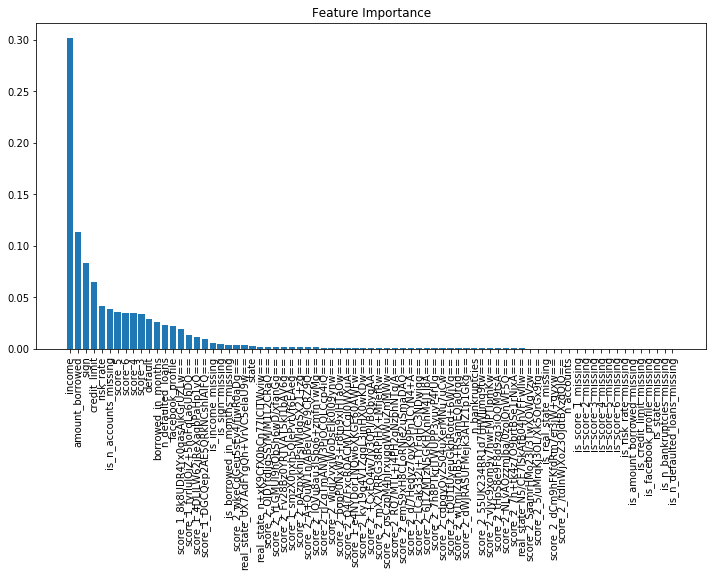

In [5]:
clf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0, max_features=25, oob_score=True)

skf = StratifiedKFold( 5, shuffle=True, random_state=100)
cm = np.zeros((2,2))
aucs = []
for (fold, (i_train, i_test)) in enumerate(skf.split(X_train,y_train)):
    clf.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = clf.predict_proba(X_train.iloc[i_test])
    pred = clf.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs.append(auc)
    
    cm += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
print("AUC: %2.3f +- %2.4f" % (np.mean(aucs), np.std(aucs)))
print("\nConfusion matrix:")
print(cm)
print("\nAccuracy %2.3f" %(cm.diagonal().sum()/cm.sum()))

clf.fit(X_train,y_train)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

(11994, 2)
AUC score on fold 0: 0.768
(11993, 2)
AUC score on fold 1: 0.753
(11993, 2)
AUC score on fold 2: 0.764
(11993, 2)
AUC score on fold 3: 0.765
(11993, 2)
AUC score on fold 4: 0.763
AUC: 0.763 +- 0.0052

Confusion matrix:
[[36501. 13955.]
 [ 3173.  6337.]]

Accuracy 0.714


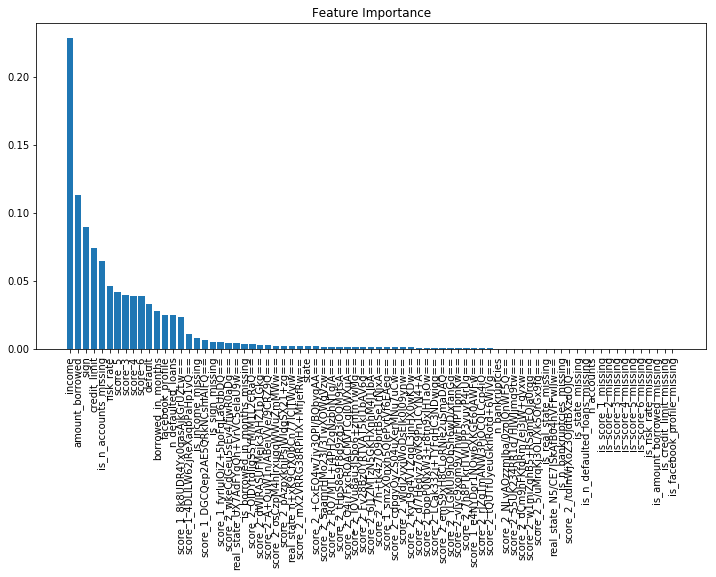

In [6]:
clf2 = BalancedRandomForestClassifier(n_estimators=250, max_depth=10,random_state=0,max_features=25, oob_score=True)

cm2 = np.zeros((2,2))
aucs2 = []
for (fold, (i_train, i_test)) in enumerate(skf.split(X_train,y_train)):
    clf2.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = clf2.predict_proba(X_train.iloc[i_test])
    pred = clf2.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs2.append(auc)
    
    cm2 += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
print("AUC: %2.3f +- %2.4f" % (np.mean(aucs2), np.std(aucs2)))
print("\nConfusion matrix:")
print(cm2)
print("\nAccuracy %2.3f" %(cm2.diagonal().sum()/cm2.sum()))

clf2.fit(X_train,y_train)
importances2 = clf2.feature_importances_

indices = np.argsort(importances2)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances2[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

In [7]:
clf2.fit(X_train, y_train)
my_predictions = pd.DataFrame(clf.predict_proba(X_test)[:, 1], columns=["predictions"], index=X_test.index)
my_predictions.to_csv("predictions.csv")
my_predictions

,predictions
ids,
e4366223-7aa2-0904-7a47-66479ae46b2a,0.111833
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,0.261568
a90d3929-86ec-2414-89ba-543776b0e82b,0.151208
c5b96a7f-389a-28d0-242d-95db05e69da0,0.465195
1b461faa-926d-565d-b15d-0b452968ac81,0.232135
ca467139-2fe3-786b-b473-9bed607e71dc,0.051763
9d1cf9f2-0134-f173-b12a-df80ae8cfed0,0.068157
0895a45f-d761-8668-b7db-a1175f46af4c,0.238062
7dc64bfe-1d62-4a68-2287-3b272ad30208,0.675363
